# 문제6: 국가 및 출연배우 탐색

## 수행목표

- KMRD 데이터셋 국가, 출연배우 데이터를 확인하고 시각화한다.

## 수행단계

- 국가 탐색
  - 국가별 영화 개수를 확인하라. (Bar chart)
- 출연배우 탐색
  - 가장 많은 영화에 주연으로 출연한 배우를 찾아라.
  - 조연으로 가장 많은 영화에 출연한 배우를 찾아라.
  - 주연으로 출연한 영화(5편 이상 출연)들의 평균 평점이 가장 높은 영화(평점 10개 이상)의 주연 배우를 찾아라. (상위 3개 영화 등 조건을 변경할 수 있게 처리)

## 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import ipywidgets as widgets
from IPython.display import display, clear_output

## 데이터셋 확인

In [2]:
KMRD_PATH = "kmrd-small"

### KMRD (Korean Movie Recommender system Dataset)

In [3]:
kmrd_castings_path = os.path.join(KMRD_PATH, "castings.csv")
kmrd_countries_path = os.path.join(KMRD_PATH, "countries.csv")
kmrd_genres_path   = os.path.join(KMRD_PATH, "genres.csv")
kmrd_movies_path   = os.path.join(KMRD_PATH, "movies.txt")
kmrd_peoples_path  = os.path.join(KMRD_PATH, "peoples.txt")
kmrd_rates_path    = os.path.join(KMRD_PATH, "rates.csv")

In [4]:

# Load CSV files
df_kmrd_castings  = pd.read_csv(kmrd_castings_path)
df_kmrd_countries = pd.read_csv(kmrd_countries_path)
df_kmrd_genres    = pd.read_csv(kmrd_genres_path)
df_kmrd_rates     = pd.read_csv(kmrd_rates_path)

# Load txt files
df_kmrd_peoples   = pd.read_csv(kmrd_peoples_path, sep='\t', engine='python')

In [5]:
missing_movie_ids = set();

def extract_eng_year(s, year_kor=None):
    """
    If s matches the pattern: "Something , 4-digit-year"
    return (english_title, year_original_as_float).
    Otherwise, return (s, None).
    """
    pattern = r"^(.*?)\s*,\s*(\d{4})$"
    match = re.match(pattern, s.strip())
    if match:
        eng = match.group(1).strip()
        yr  = float(match.group(2))
        return eng, yr
    else:
        if year_kor and year_kor.isnumeric() and s.strip() == year_kor:
            return None, float(s.strip())
        return s.strip(), None

def parse_movies_txt(filepath):
    """
    Reads the movies.txt line by line, ignoring empty lines,
    and splits into columns: 
        movie (str), 
        title_kor (str), 
        title_eng (str), 
        year_original (float), 
        year_korea (float), 
        grade (str)
    
    year_original and year_korea might be NaN if not found.
    We ONLY drop lines if BOTH the Korean title AND English title are missing.
    """
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        f.readline()
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split('\t')
            if len(parts) < 2:
                missing_movie_ids.add(parts[0])
                continue
            
            movie_id    = None
            title_kor   = None
            title_eng   = None
            year_original   = None
            year_korea  = None
            grade       = None
            
            movie_id  = parts[0].strip() if len(parts) >= 1 else None
            title_kor = parts[1].strip() if len(parts) >= 2 else None

            extra_cols = parts[2:]
            

            # Possible cases:
            #  - 0 extra_cols => [movie_id, title_kor]
            #  - 1 extra_cols => [movie_id, title_kor, title_eng+year]
            #  - 2 extra_cols => [movie_id, title_kor, title_eng+year, year_korea]
            #  - 3 extra_cols => [movie_id, title_kor, title_eng+year, year_korea, grade]
            #                 => [movie_id, title_kor, year, year_korea, grade]
            #  - 4 extra_cols => [movie_id, title_kor, title_eng+year, year_korea, grade, ???]
            
            if len(extra_cols) == 1:
                t_eng, y_original = extract_eng_year(extra_cols[0])
                title_eng   = t_eng
                year_original   = y_original
            elif len(extra_cols) == 2:
                t_eng, y_original = extract_eng_year(extra_cols[0])
                title_eng  = t_eng
                year_original  = y_original
                
                try:
                    year_korea = float(extra_cols[1])
                except ValueError:
                    grade = extra_cols[1].strip()
            elif len(extra_cols) == 3:
                t_eng, y_original = extract_eng_year(extra_cols[0], extra_cols[1])
                title_eng  = t_eng
                year_original  = y_original
                
                try:
                    year_korea = float(extra_cols[1])
                except ValueError:
                    if extra_cols[1].strip():
                        grade = extra_cols[1].strip()
                
                if grade is None:
                    grade = extra_cols[2].strip()
            else:
                if len(extra_cols) == 0:
                    pass
                else:
                    t_eng, y_original = extract_eng_year(extra_cols[0])
                    title_eng  = t_eng
                    year_original  = y_original
                    if len(extra_cols) >= 2:
                        try:
                            year_korea = float(extra_cols[1])
                        except ValueError:
                            grade = extra_cols[1].strip()
                    if len(extra_cols) >= 3 and grade is None:
                        grade = extra_cols[2].strip()
            
            records.append({
                "movie": movie_id if movie_id else None,
                "title_kor": title_kor if title_kor else None,
                "title_eng": title_eng if title_eng else None,
                "year_original": year_original,
                "year_korea": year_korea,
                "grade": grade if grade else None
            })
    
    df = pd.DataFrame(records)
    
    df = df[df['movie'].notna() & (df['movie'] != '')]
    
    mask_titles_missing = df['title_kor'].isna() & df['title_eng'].isna()
    df = df[~mask_titles_missing]
    
    return df

In [6]:
df_kmrd_movies = parse_movies_txt(kmrd_movies_path)
print(df_kmrd_movies.shape)
df_kmrd_movies.head(100)

(992, 6)


,movie,title_kor,title_eng,year_original,year_korea,grade
0,10001,시네마 천국,Cinema Paradiso,1988.0,2013.0,전체 관람가
1,10002,빽 투 더 퓨쳐,Back To The Future,1985.0,2015.0,12세 관람가
2,10003,빽 투 더 퓨쳐 2,Back To The Future Part 2,1989.0,2015.0,12세 관람가
3,10004,빽 투 더 퓨쳐 3,Back To The Future Part III,1990.0,1990.0,전체 관람가
4,10005,스타워즈 에피소드 4 - 새로운 희망,Star Wars,1977.0,1997.0,PG
...,...,...,...,...,...,...
95,10096,고스트버스터즈 2,Ghostbusters II,1989.0,1990.0,PG
96,10097,굿모닝 베트남,"Good Morning, Vietnam",1987.0,NaN,15세 관람가
97,10098,자유의 댄스,Footloose,1984.0,NaN,PG
98,10099,남과 여,"Un Homme Et Une Femme , A Man And A Woman",1966.0,1979.0,15세 관람가


#### 데이터 조회 및 검사

##### Genres 정보

In [7]:
df_kmrd_genres.info()
df_kmrd_genres.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2025 entries, 0 to 2024
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   movie   2025 non-null   int64 
 1   genre   2025 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.8+ KB


,movie,genre
0,10001,드라마
1,10001,멜로/로맨스
2,10002,SF
3,10002,코미디
4,10003,SF


In [8]:
print("Unique values in KMRD Genres:")
print(df_kmrd_genres.nunique())

Unique values in KMRD Genres:
movie    964
genre     20
dtype: int64


##### Movies 정보

In [9]:
df_kmrd_movies.info()
df_kmrd_movies.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992 entries, 0 to 991
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie          992 non-null    object 
 1   title_kor      992 non-null    object 
 2   title_eng      977 non-null    object 
 3   year_original  987 non-null    float64
 4   year_korea     609 non-null    float64
 5   grade          957 non-null    object 
dtypes: float64(2), object(4)
memory usage: 46.6+ KB


,movie,title_kor,title_eng,year_original,year_korea,grade
0,10001,시네마 천국,Cinema Paradiso,1988.0,2013.0,전체 관람가
1,10002,빽 투 더 퓨쳐,Back To The Future,1985.0,2015.0,12세 관람가
2,10003,빽 투 더 퓨쳐 2,Back To The Future Part 2,1989.0,2015.0,12세 관람가
3,10004,빽 투 더 퓨쳐 3,Back To The Future Part III,1990.0,1990.0,전체 관람가
4,10005,스타워즈 에피소드 4 - 새로운 희망,Star Wars,1977.0,1997.0,PG


In [10]:
print("Unique values in KMRD Movies:")
print(df_kmrd_movies.nunique())

Unique values in KMRD Movies:
movie            992
title_kor        969
title_eng        957
year_original     79
year_korea        72
grade              9
dtype: int64


##### Ratings 정보

In [11]:
df_kmrd_rates.info()
df_kmrd_rates.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140710 entries, 0 to 140709
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   user    140710 non-null  int64
 1   movie   140710 non-null  int64
 2   rate    140710 non-null  int64
 3   time    140710 non-null  int64
dtypes: int64(4)
memory usage: 4.3 MB


,user,movie,rate,time
0,0,10003,7,1494128040
1,0,10004,7,1467529800
2,0,10018,9,1513344120
3,0,10021,9,1424497980
4,0,10022,7,1427627340


In [12]:
print("Unique values in KMRD Rates:")
df_kmrd_rates.nunique()

Unique values in KMRD Rates:


user      52028
movie       600
rate         10
time     136972
dtype: int64

##### Peoples 정보

In [13]:
df_kmrd_peoples.info()
df_kmrd_peoples.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   people    7172 non-null   int64 
 1   korean    7172 non-null   object
 2   original  6305 non-null   object
dtypes: int64(1), object(2)
memory usage: 168.2+ KB


,people,korean,original
0,5,아담 볼드윈,Adam Baldwin
1,8,애드리안 라인,Adrian Lyne
2,9,에이단 퀸,Aidan Quinn
3,13,구로사와 아키라,Akira Kurosawa
4,15,알 파치노,Al Pacino


In [14]:
print("Unique values in KMRD Peoples:")
print(df_kmrd_peoples.nunique())

Unique values in KMRD Peoples:
people      7172
korean      7153
original    6299
dtype: int64


##### Countries 정보

In [15]:
df_kmrd_countries.info()
df_kmrd_countries.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movie    1109 non-null   int64 
 1   country  1109 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.5+ KB


,movie,country
0,10001,이탈리아
1,10001,프랑스
2,10002,미국
3,10003,미국
4,10004,미국


In [16]:
print("Unique values in KMRD Countries:")
print(df_kmrd_countries.nunique())

Unique values in KMRD Countries:
movie      990
country     36
dtype: int64


In [17]:
df_kmrd_countries = df_kmrd_countries.dropna()
df_kmrd_countries = df_kmrd_countries.drop_duplicates()
print("KMRD Countries shape after dropping na values:", df_kmrd_countries.shape)

KMRD Countries shape after dropping na values: (1109, 2)


## 데이터 결측치 및 이상치 확인

#### 결측치 확인

- movies.txt 의 경우 이미 결측치가 제거된 상태임

In [18]:
print("KMRD Genres shape:", df_kmrd_genres.shape)
print("KMRD Movies shape:", df_kmrd_movies.shape)
print("KMRD Rates shape:", df_kmrd_rates.shape)

KMRD Genres shape: (2025, 2)
KMRD Movies shape: (992, 6)
KMRD Rates shape: (140710, 4)


In [19]:
df_kmrd_genres = df_kmrd_genres.dropna()
df_kmrd_genres = df_kmrd_genres.drop_duplicates()
print("KMRD Genres shape after dropping na values:", df_kmrd_genres.shape)

KMRD Genres shape after dropping na values: (2025, 2)


In [20]:
df_kmrd_rates = df_kmrd_rates.dropna()
df_kmrd_rates = df_kmrd_rates.drop_duplicates()
print("KMRD Ratings shape after dropping na values:", df_kmrd_rates.shape)

KMRD Ratings shape after dropping na values: (140678, 4)


#### 이상치 확인

##### Ratings 정보

In [21]:
print(df_kmrd_rates['rate'].describe())

out_of_range = df_kmrd_rates[ (df_kmrd_rates['rate'] < 1) | (df_kmrd_rates['rate'] > 10) ]
print("Out-of-range rating rows:", len(out_of_range))

df_kmrd_rates['zscore_rate'] = stats.zscore(df_kmrd_rates['rate'].astype(float))
outliers = df_kmrd_rates[ df_kmrd_rates['zscore_rate'].abs() > 3 ]
print("Potential outliers (|z|>3) in rating:", len(outliers))

df_kmrd_rates_zscore = df_kmrd_rates[ df_kmrd_rates['zscore_rate'].abs() <= 3 ]
print("KMRD Ratings shape after dropping invalid ratings:", df_kmrd_rates_zscore.shape)

user_counts = df_kmrd_rates_zscore['user'].value_counts()
user_counts = user_counts[user_counts >= 30]
df_kmrd_rates_rating_count = df_kmrd_rates_zscore[df_kmrd_rates_zscore['user'].isin(user_counts.index)]
print("KMRD Ratings shape after dropping users with less than 30 ratings:", df_kmrd_rates_rating_count.shape)

count_by_movie = df_kmrd_rates.groupby('movie')['rate'].count().reset_index(name='rating_count')
df_kmrd_rates_movie_count = df_kmrd_rates.merge(count_by_movie, on='movie', how='left', validate='many_to_one')
threshold = 30
df_kmrd_rates_movie_count_filtered = df_kmrd_rates_movie_count[df_kmrd_rates_movie_count['rating_count'] >= threshold].copy()
print("Total movies before filtering:", df_kmrd_rates['movie'].nunique())
print("Total movies after filtering (>=30 ratings):", df_kmrd_rates_movie_count_filtered['movie'].nunique())

df_kmrd_rates = df_kmrd_rates.drop('zscore_rate', axis=1)

count    140678.000000
mean          8.953433
std           2.105626
min           1.000000
25%           9.000000
50%          10.000000
75%          10.000000
max          10.000000
Name: rate, dtype: float64
Out-of-range rating rows: 0
Potential outliers (|z|>3) in rating: 5964
KMRD Ratings shape after dropping invalid ratings: (134714, 5)
KMRD Ratings shape after dropping users with less than 30 ratings: (29502, 5)
Total movies before filtering: 600
Total movies after filtering (>=30 ratings): 409


## 데이터 조회 및 시각화

In [22]:
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

### 국가별 영화 개수

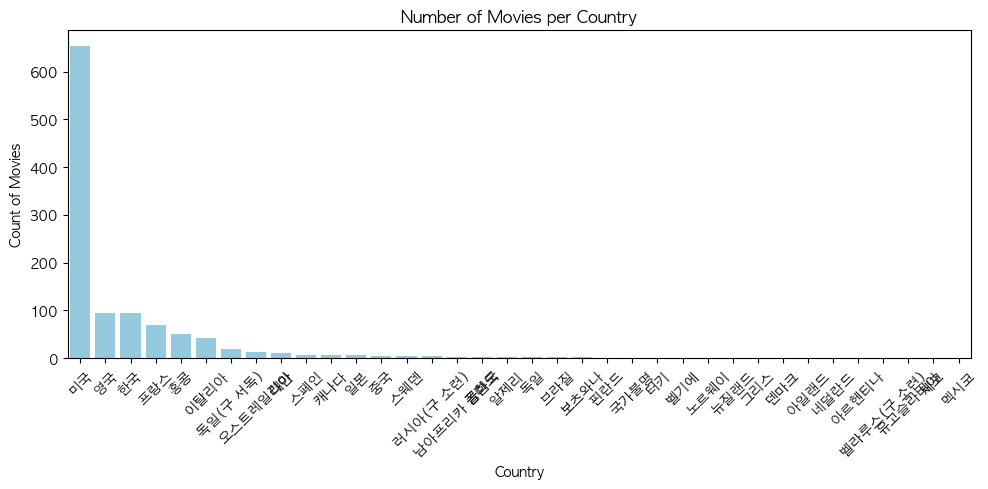

Country Count:
 country
미국            654
영국             94
한국             94
프랑스            70
홍콩             51
이탈리아           43
독일(구 서독)       20
오스트레일리아        12
대만             10
스페인             7
캐나다             6
일본              6
중국              5
스웨덴             4
러시아(구 소련)       4
남아프리카 공화국       3
폴란드             3
알제리             2
독일              2
브라질             2
보츠와나            2
핀란드             1
국가불명            1
터키              1
벨기에             1
노르웨이            1
뉴질랜드            1
그리스             1
덴마크             1
아일랜드            1
네덜란드            1
아르헨티나           1
벨라루스(구 소련)      1
유고슬라비아          1
체코              1
멕시코             1
Name: count, dtype: int64


In [23]:
country_counts = df_kmrd_countries['country'].value_counts()

plt.figure(figsize=(10, 5))
sns.barplot(x=country_counts.index, y=country_counts.values, color='skyblue')
plt.title("Number of Movies per Country")
plt.xlabel("Country")
plt.ylabel("Count of Movies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Country Count:\n", country_counts.head(36))

### 출연배우 탐색

#### 가장 많은 영화에 주연으로 출연한 배우를 찾아라.

In [24]:
df_lead = df_kmrd_castings[df_kmrd_castings['leading'] == 1].copy()

lead_counts = df_lead.groupby('people')['movie'].nunique().reset_index(name='lead_movie_count')
lead_counts = lead_counts.sort_values('lead_movie_count', ascending=False)

lead_counts = lead_counts.merge(df_kmrd_peoples, how='left', on='people')

print("\nTop 10 Actors by Number of Lead Roles:")
print(lead_counts.head(10))


Top 10 Actors by Number of Lead Roles:
   people  lead_movie_count     korean               original
0    1327                16   로버트 드 니로         Robert De Niro
1    1843                13        안성기                    NaN
2     290                11  클린트 이스트우드         Clint Eastwood
3    1507                11   실베스터 스탤론     Sylvester Stallone
4    1422                11      숀 코네리           Sean Connery
5    1336                10   로버트 레드포드         Robert Redford
6     535                10     해리슨 포드          Harrison Ford
7    1248                10     피터 셀러스          Peter Sellers
8     556                10      헨리 폰다            Henry Fonda
9      99                10  아놀드 슈왈제네거  Arnold Schwarzenegger


In [25]:
print(lead_counts.iloc[0])

people                        1327
lead_movie_count                16
korean                    로버트 드 니로
original            Robert De Niro
Name: 0, dtype: object


#### 조연으로 가장 많은 영화에 출연한 배우를 찾아라.

In [26]:
df_support = df_kmrd_castings[df_kmrd_castings['leading'] == 0].copy()

support_counts = df_support.groupby('people')['movie'].nunique().reset_index(name='support_movie_count')
support_counts = support_counts.sort_values('support_movie_count', ascending=False)

support_counts = support_counts.merge(df_kmrd_peoples, how='left', on='people')

print("\nTop 10 Actors by Number of Support Roles:")
print(support_counts.head(10))


Top 10 Actors by Number of Support Roles:
   people  support_movie_count   korean             original
0    2248                    9       우마                Wu Ma
1   40425                    7      나갑성                  NaN
2    7612                    7      박예숙                  NaN
3    2331                    6  로버트 로지아        Robert Loggia
4    1539                    6   토마스 밋첼      Thomas Mitchell
5   11043                    6   니셸 니콜스     Nichelle Nichols
6   11041                    6   조지 타케이  George Hosato Takei
7   11040                    6   제임스 두한         James Doohan
8    7619                    6      박용팔                  NaN
9    6154                    6      주호성                  NaN


##### 주연으로 출연한 영화(5편 이상 출연)들의 평균 평점이 가장 높은 영화(평점 10개 이상)의 주연 배우를 찾아라. (상위 3개 영화 등 조건을 변경할 수 있게 처리)

In [27]:
movie_stats = df_kmrd_rates.groupby('movie')['rate'].agg(
    avg_rating = 'mean',
    rating_count = 'count'
).reset_index()

print(movie_stats.head(10))

   movie  avg_rating  rating_count
0  10001    9.294360          3635
1  10002    9.416778          3004
2  10003    9.270981           989
3  10004    9.120000           700
4  10005    9.048619           905
5  10006    9.115127           747
6  10007    9.034335           699
7  10008    8.805785           242
8  10009    8.462185           119
9  10011    5.250000            76


In [28]:
df_lead = df_kmrd_castings[df_kmrd_castings['leading'] == 1].copy()
df_lead = pd.merge(df_lead, movie_stats, on='movie', how='left', validate='many_to_one')

In [29]:
def get_top_lead_actors(df_lead, df_peoples, min_movie_ratings=10, min_lead_roles=5, top_n=3):
    """
    Return the top N lead actors by average rating among the movies 
    that have at least `min_movie_ratings` ratings. 
    Actor must have at least `min_lead_roles` lead appearances.
    """
    df_filtered = df_lead[df_lead['rating_count'] >= min_movie_ratings].copy()
    
    actor_stats = df_filtered.groupby('people').agg(
        num_lead_movies = ('movie', 'nunique'),
        mean_rating     = ('avg_rating', 'mean')
    ).reset_index()
    
    actor_stats = actor_stats[actor_stats['num_lead_movies'] >= min_lead_roles].copy()
    
    actor_stats = actor_stats.sort_values('mean_rating', ascending=False)
    
    actor_stats = actor_stats.merge(df_peoples, how='left', on='people')
    
    return actor_stats.head(top_n)

results = get_top_lead_actors(df_lead, df_kmrd_peoples, min_movie_ratings=10, min_lead_roles=5, top_n=3)
print("\nTop 3 Lead Actors by Highest Average Movie Rating (>=10 ratings per movie, >=5 lead roles):")
print(results)


Top 3 Lead Actors by Highest Average Movie Rating (>=10 ratings per movie, >=5 lead roles):
   people  num_lead_movies  mean_rating    korean         original
0     226                5     9.301997    찰리 채플린  Charles Chaplin
1    1945                6     8.988406       장국영              NaN
2    1327               10     8.912060  로버트 드 니로   Robert De Niro


In [30]:
min_movie_ratings_w = widgets.IntSlider(value=10, min=1, max=100, step=1, description='Min Movie Ratings:')
min_lead_roles_w    = widgets.IntSlider(value=5, min=1, max=30, step=1, description='Min Lead Roles:')
top_n_w             = widgets.IntSlider(value=3, min=1, max=20, step=1, description='Top N:')

button_show = widgets.Button(description='Show Results')

def on_button_show_click(b):
    clear_output(wait=True)
    display(min_movie_ratings_w, min_lead_roles_w, top_n_w, button_show)
    
    min_mov = min_movie_ratings_w.value
    min_lead = min_lead_roles_w.value
    n_top = top_n_w.value
    
    results = get_top_lead_actors(df_lead, df_kmrd_peoples, 
                                  min_movie_ratings=min_mov, 
                                  min_lead_roles=min_lead, 
                                  top_n=n_top)
    if results.empty:
        print(f"No actor meets the criteria (min_movie_ratings={min_mov}, min_lead_roles={min_lead}).")
    else:
        print(results)

button_show.on_click(on_button_show_click)
display(min_movie_ratings_w, min_lead_roles_w, top_n_w, button_show)

IntSlider(value=10, description='Min Movie Ratings:', min=1)

IntSlider(value=5, description='Min Lead Roles:', max=30, min=1)

IntSlider(value=3, description='Top N:', max=20, min=1)

Button(description='Show Results', style=ButtonStyle())

## 결론

- 찰리 채플린과 장국영은 위대하다